## LightGBM demo for solar irradiance forecasting

*by Natanon Tongamrak*

This is a demo of LightGBM presented in our manuscript `Developing a Thailand solar irradiance map using Himawari-8 satellite imageries and deep learning models'. You can browse to each of the following topics: 

- [Data Processing](#data-processing)
- [Model Training](#model-training)
- [Inference on test dataset](#run-the-model-on-test-set)
- [Performance evaluation](#performance-evaluation)

Packages

In [1]:
import os
import pandas as pd
import numpy as np
import joblib 
import lightgbm 
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Processing

Download data from [Google drive](https://drive.google.com/drive/folders/1vsWaPqMnBp1Whd2GhcbVOdFj4JofFQ-M?usp=sharing) and import them for trainin, testing, and validation

In [2]:
train_df = pd.read_csv("dataset/preprocessed_data/train_data.csv", parse_dates=['Datetime'])
val_df   = pd.read_csv("dataset/preprocessed_data/val_data.csv", parse_dates=['Datetime'])
test_df  = pd.read_csv("dataset/preprocessed_data/test_data.csv", parse_dates=['Datetime'])

The imported data contains the results of a trained LGBM model. These results can be discarded if you wish to explore a new experiment.

In [3]:
train_df

,Datetime,I,sitename,cos_zna,AM,Iclr,k_bar,Date,condition,CI,...,long,minute,hour,hour_encode1,day,month,site_date,I_LGBM,Iclr_R,Ireg
0,2022-04-04 05:00:00+07:00,0.00000,1,-0.314248,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,100.519403,0,5,-6.5,94,4,1 2022-04-04,0.000000,0.000000,0.000000
1,2022-04-04 05:15:00+07:00,0.00000,1,-0.254260,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,100.519403,15,5,-6.5,94,4,1 2022-04-04,0.000000,0.000000,0.000000
2,2022-04-04 05:30:00+07:00,0.00000,1,-0.193091,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,100.519403,30,5,-6.5,94,4,1 2022-04-04,0.000000,0.000000,0.000000
3,2022-04-04 05:45:00+07:00,0.00000,1,-0.131003,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,100.519403,45,5,-6.5,94,4,1 2022-04-04,0.000000,0.000000,0.000000
4,2022-04-04 06:00:00+07:00,1.46322,1,-0.068261,37.919608,0.000000,1.062331,2022-04-04,clr,73.0,...,100.519403,0,6,-5.5,94,4,1 2022-04-04,44.497077,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599624,2023-06-27 16:00:00+07:00,237.40810,29,0.599656,1.664633,558.927494,0.494951,2023-06-27,cloudy,161.0,...,98.929270,0,16,4.5,178,6,29 2023-06-27,235.885851,123522.976093,183.531906
599625,2023-06-27 16:15:00+07:00,149.78840,29,0.550854,1.811307,502.625183,0.494951,2023-06-27,cloudy,119.0,...,98.929270,15,16,4.5,178,6,29 2023-06-27,160.290142,116106.417303,178.476824
599626,2023-06-27 16:30:00+07:00,144.26530,29,0.499933,1.994559,444.188959,0.494951,2023-06-27,cloudy,134.0,...,98.929270,30,16,4.5,178,6,29 2023-06-27,154.637402,106605.350118,142.453948
599627,2023-06-27 16:45:00+07:00,131.27480,29,0.447110,2.228185,384.011054,0.494951,2023-06-27,cloudy,155.0,...,98.929270,45,16,4.5,178,6,29 2023-06-27,138.371902,87554.520397,123.846723


#### Create lag features

Concatenate the features from previous time stamp such that the model can learn the temporal changes.

In [4]:
def create_lagged_features(full_df):
    # Create an empty DataFrame to store the lagged features
    lagged_features_df = pd.DataFrame()

    # Loop through each site
    for site in full_df['sitename'].unique():
        site_df = full_df[full_df['sitename'] == site].copy()
        site_df.set_index('Datetime', inplace=True)
        
        for lag in [1, 2, 3, 4]:
            # Create lagged features for 'CI'
            site_df[f'CI_lagged_{lag*15}'] = site_df['CI'].shift(periods=lag, freq='15min')
            
            # Create lagged features for 'R'
            site_df[f'R_lagged_{lag*15}'] = site_df['R'].shift(periods=lag, freq='15min')
        
        site_df = site_df.reset_index()
        lagged_features_df = pd.concat([lagged_features_df, site_df], ignore_index=True)

    # Drop rows with NaN values created due to lagging
    # lagged_features_df.dropna(inplace=True)

    # Reset index of the final DataFrame
    lagged_features_df.reset_index(drop=True, inplace=True)
    return lagged_features_df

train_df = create_lagged_features(train_df)
val_df   = create_lagged_features(val_df)
test_df  = create_lagged_features(test_df)



In [5]:
train_df

,Datetime,I,sitename,cos_zna,AM,Iclr,k_bar,Date,condition,CI,...,Iclr_R,Ireg,CI_lagged_15,R_lagged_15,CI_lagged_30,R_lagged_30,CI_lagged_45,R_lagged_45,CI_lagged_60,R_lagged_60
0,2022-04-04 05:00:00+07:00,0.00000,1,-0.314248,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-04 05:15:00+07:00,0.00000,1,-0.254260,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-04 05:30:00+07:00,0.00000,1,-0.193091,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2022-04-04 05:45:00+07:00,0.00000,1,-0.131003,37.919608,0.000000,1.062331,2022-04-04,clr,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,2022-04-04 06:00:00+07:00,1.46322,1,-0.068261,37.919608,0.000000,1.062331,2022-04-04,clr,73.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599624,2023-06-27 16:00:00+07:00,237.40810,29,0.599656,1.664633,558.927494,0.494951,2023-06-27,cloudy,161.0,...,123522.976093,183.531906,30.0,203.0,103.0,200.0,145.0,222.0,145.0,222.0
599625,2023-06-27 16:15:00+07:00,149.78840,29,0.550854,1.811307,502.625183,0.494951,2023-06-27,cloudy,119.0,...,116106.417303,178.476824,161.0,221.0,30.0,203.0,103.0,200.0,145.0,222.0
599626,2023-06-27 16:30:00+07:00,144.26530,29,0.499933,1.994559,444.188959,0.494951,2023-06-27,cloudy,134.0,...,106605.350118,142.453948,119.0,231.0,161.0,221.0,30.0,203.0,103.0,200.0
599627,2023-06-27 16:45:00+07:00,131.27480,29,0.447110,2.228185,384.011054,0.494951,2023-06-27,cloudy,155.0,...,87554.520397,123.846723,134.0,240.0,119.0,231.0,161.0,221.0,30.0,203.0


In [6]:
final_train_df = train_df.drop(columns=[f'R_lagged_{min}' for min in [15, 30, 45, 60]]+[f'CI_lagged_{min}' for min in [15, 30, 45, 60]]+['I_LGBM'])
final_val_df   = val_df.drop(columns=[f'R_lagged_{min}' for min in [15, 30, 45, 60]]  +[f'CI_lagged_{min}' for min in [15, 30, 45, 60]]+['I_LGBM'])
final_test_df  = test_df.drop(columns=[f'R_lagged_{min}' for min in [15, 30, 45, 60]] +[f'CI_lagged_{min}' for min in [15, 30, 45, 60]]+['I_LGBM'])

train_df = train_df.dropna()
val_df   = val_df.dropna()
test_df  = test_df.dropna()

### Model training

Select path to save the output files

In [ ]:
path_to_save_result = "results_LightGBM" # You can change the directory to the path that you want to save the result
os.makedirs(path_to_save_result)

Select the types of input features ...

In [7]:
feat_list = "all" 

if feat_list == "all":

    features_list= ['Iclr', 
                    'R', 
                    'CI',
                    'R_lagged_15', 
                    'CI_lagged_15',
                    'R_lagged_30', 
                    'CI_lagged_30', 
                    'R_lagged_45', 
                    'CI_lagged_45', 
                    'R_lagged_60', 
                    'CI_lagged_60', 
                    'hour_encode1', 
                    'latt', 'long',
                    'day', 'month',
                    'Inwp', 'Tnwp'
                    ]
elif feat_list == "I_wo_nwp":

    features_list= ['Iclr', 
                    'R', 
                    'CI',
                    'R_lagged_15', 
                    'CI_lagged_15',
                    'R_lagged_30', 
                    'CI_lagged_30', 
                    'R_lagged_45', 
                    'CI_lagged_45', 
                    'R_lagged_60', 
                    'CI_lagged_60', 
                    'hour_encode1', 
                    'latt', 'long',
                    'day', 'month'
                    ]
    
elif feat_list == "I_wo_nwp_wo_latlong":

    features_list= ['Iclr', 
                    'R', 
                    'CI',
                    'R_lagged_15', 
                    'CI_lagged_15',
                    'R_lagged_30', 
                    'CI_lagged_30', 
                    'R_lagged_45', 
                    'CI_lagged_45', 
                    'R_lagged_60', 
                    'CI_lagged_60', 
                    'hour_encode1',  
                    'day', 'month'
                    ]
    
target_col = ['I']

X_train = train_df[features_list][train_df['is_target']]
X_val = val_df[features_list][val_df['is_target']]
X_test = test_df[features_list][test_df['is_target']]

y_train = train_df[target_col][train_df['is_target']]
y_val = val_df[target_col][val_df['is_target']]
y_test = test_df[target_col][test_df['is_target']]

Parameter setting and training

In [8]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 200,
    'min_child_samples':100,
    'learning_rate': 0.1,
    'n_estimators':500,
    'max_depth' : 15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model = lightgbm.LGBMRegressor(**params)

model.fit(X_train, y_train) 
 


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              max_depth=15, metric='rmse', min_child_samples=100,
              n_estimators=500, num_leaves=200, objective='regression',
              verbose=-1)

### Run the model on test set

In [9]:
y_pred = model.predict(X_test)


eval_df = test_df[['sitename', 'Datetime','hour', 'I']][test_df['is_target']]
eval_df['Ihat'] = y_pred
eval_df['Date'] = pd.to_datetime(test_df['Datetime'].dt.date)
eval_df = eval_df[eval_df['hour'].isin([hour for hour in range(7,18)])]


overall_mae  = mean_absolute_error(eval_df['I'], eval_df['Ihat'])
overall_rmse = mean_squared_error(eval_df['I'], eval_df['Ihat'], squared=False)
overall_mbe  = np.mean(eval_df['Ihat']-eval_df['I'])

print(overall_mae, overall_rmse, overall_mbe)

78.59388035156805 118.97928621261613 -0.48382570363812893


/home/nv4090-01/anaconda3/envs/solarmap/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
train_df['I_LGBM'] = model.predict(train_df[features_list])
val_df['I_LGBM']   = model.predict(val_df[features_list])
test_df['I_LGBM']  = model.predict(test_df[features_list])

train_df['I_LGBM'] = train_df['I_LGBM'].apply(lambda x: max(x, 0))
val_df['I_LGBM']   = val_df['I_LGBM'].apply(lambda x: max(x, 0))
test_df['I_LGBM']  = test_df['I_LGBM'].apply(lambda x: max(x, 0))

/tmp/ipykernel_425972/3641745511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['I_LGBM'] = model.predict(train_df[features_list])
/tmp/ipykernel_425972/3641745511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['I_LGBM'] = train_df['I_LGBM'].apply(lambda x: max(x, 0))


### Performance evaluation

In [11]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [12]:
# Define a function to calculate MAE, RMSE, and MBE
def calculate_metrics(df):
    # Filter the DataFrame to include only the hours from 07:00 to 17:00
    filtered_df = df[df['Datetime'].dt.hour.isin([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])]
    
    mae = np.mean(np.abs(filtered_df['I'] - filtered_df['I_LGBM']))
    rmse = np.sqrt(np.mean((filtered_df['I'] - filtered_df['I_LGBM'])**2))
    mbe = np.mean(filtered_df['I_LGBM'] - filtered_df['I'])
    return pd.Series({'MAE': mae, 'RMSE': rmse, 'MBE': mbe})

# Ensure 'Datetime' is a datetime type and add 'hour' column
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'])
test_df['hour'] = test_df['Datetime'].dt.hour

# Create the 'kavg_condition' column based on 'average_k'
bins = [0, 0.6, 0.9, float('inf')]
labels = ['cloudy', 'partly_cloudy', 'clr']
test_df['kavg_condition'] = pd.cut(test_df['k_bar'], bins=bins, labels=labels, right=False)

# Calculate metrics for 'condition'
condition_metrics_df = test_df[test_df['is_target']].groupby('condition').apply(calculate_metrics)
condition_metrics_df = condition_metrics_df.reindex(['clr', 'partly_cloudy', 'cloudy'], fill_value=np.nan)

# Calculate metrics for 'kavg_condition'
kavg_condition_metrics_df = test_df[test_df['is_target']].groupby('kavg_condition').apply(calculate_metrics)
kavg_condition_metrics_df = kavg_condition_metrics_df.reindex(['clr', 'partly_cloudy', 'cloudy'], fill_value=np.nan)

# Print the resulting DataFrames
print("Metrics for 'ROC condition':")
print(condition_metrics_df)
print("\nMetrics for 'kavg_condition':")
print(kavg_condition_metrics_df)

Metrics for 'ROC condition':
                     MAE        RMSE        MBE
condition                                      
clr            19.734109   36.695489  -7.859745
partly_cloudy  75.930630  115.127904  -7.483933
cloudy         97.005172  138.533078  23.072944

Metrics for 'kavg_condition':
                      MAE        RMSE        MBE
kavg_condition                                  
clr             41.665535   68.989742 -14.897454
partly_cloudy   88.248576  128.296988  -3.934770
cloudy          97.005172  138.533078  23.072944


/tmp/ipykernel_425972/1137472846.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  condition_metrics_df = test_df[test_df['is_target']].groupby('condition').apply(calculate_metrics)
/tmp/ipykernel_425972/1137472846.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  kavg_condition_metrics_df = test_df[test_df['is_target']].groupby('kavg_condition').apply(calculate_metrics)
/tmp/ipykernel_425972/1137472846.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is

Plotting MAE and MBE across daily hours (7:00 - 17:00)

/tmp/ipykernel_425972/1948407399.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sky_condition'] = df['condition'].apply(


Overall MAE [roc]:  78.585
Overall RMSE [roc]: 118.975
MAE by sky_condition [roc]
   sky_condition        MAE
0          clear  19.734109
1         cloudy  97.005172
2  partly_cloudy  75.930630

RMSE by sky_condition [roc]
   sky_condition        RMSE
0          clear   36.695489
1         cloudy  138.533078
2  partly_cloudy  115.127904


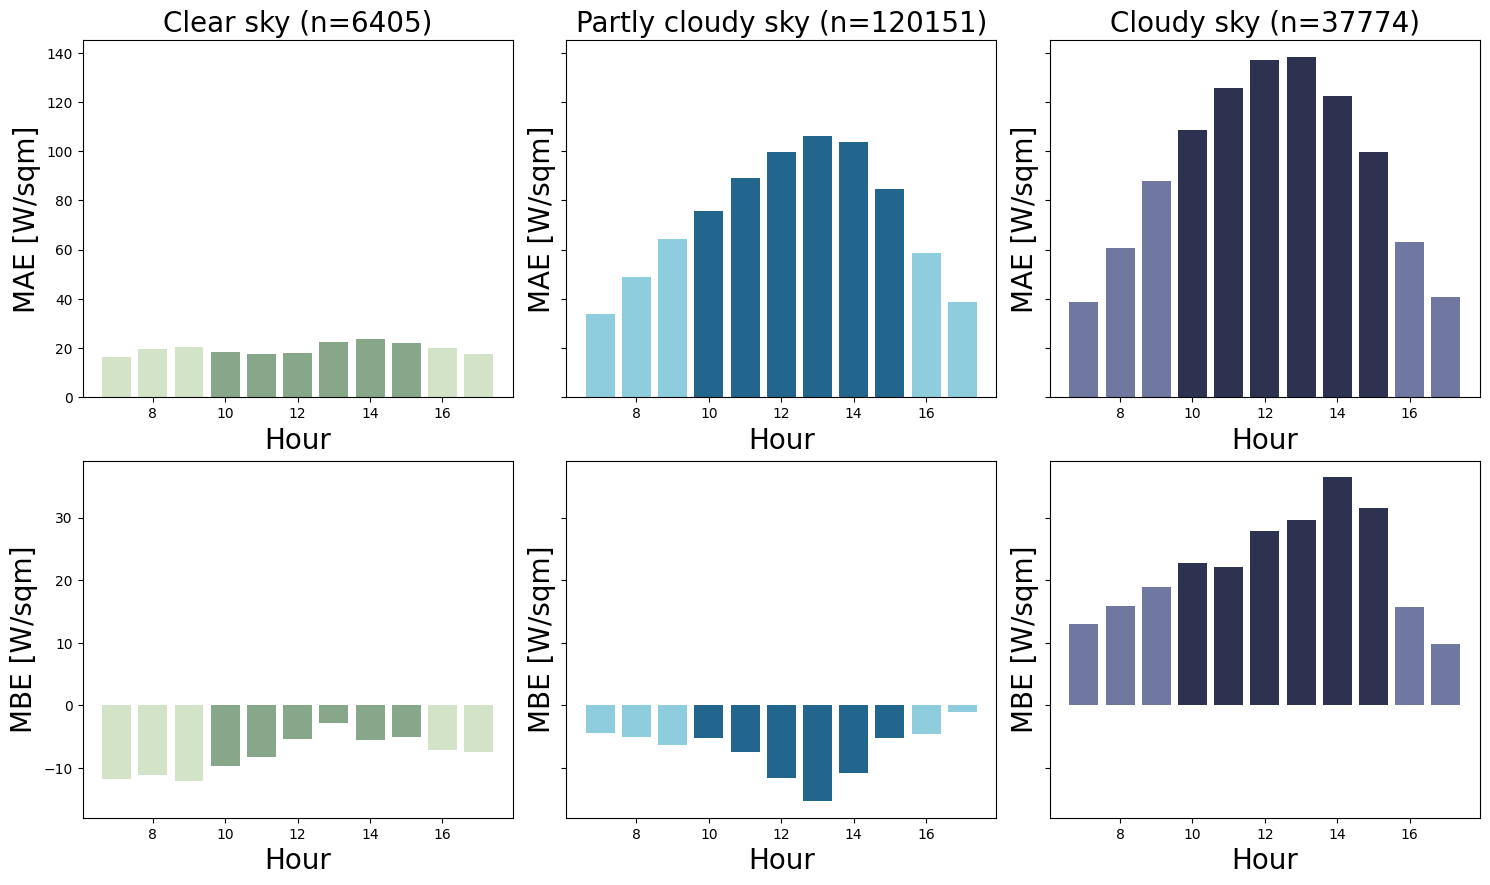

In [13]:
def evaluation_skycondition(df, condition_spit_sky_condition="k_bar"):
    
    if condition_spit_sky_condition == 'k_bar':
        df['sky_condition'] = df['k_bar'].apply(
            lambda x: 'cloudy' if x < 0.6 else ('partly_cloudy' if x < 0.9 else 'clear'))
    else :
        df['sky_condition'] = df['condition'].apply(
            lambda x: 'cloudy' if x == 'cloudy' else ('partly_cloudy' if x == 'partly_cloudy' else 'clear'))

    sky_condition_mae = df.groupby('sky_condition')[['I', 'I_LGBM']].apply(lambda x: mean_absolute_error(x['I'], x['I_LGBM'])).reset_index(name='MAE')
    sky_condition_rmse = df.groupby('sky_condition')[['I', 'I_LGBM']].apply(lambda x: np.sqrt(mean_squared_error(x['I'], x['I_LGBM']))).reset_index(name='RMSE')
        
    overall_mae        = mean_absolute_error(df['I'], df['I_LGBM'])
    overall_rmse       = np.sqrt(mean_squared_error(df['I'], df['I_LGBM']))
    print('Overall MAE [%s]:  %.3f' % (condition_spit_sky_condition, overall_mae))
    print('Overall RMSE [%s]: %.3f' % (condition_spit_sky_condition, overall_rmse))
    
    print('MAE by sky_condition [%s]' % condition_spit_sky_condition)
    print(sky_condition_mae)

    print('\nRMSE by sky_condition [%s]' % condition_spit_sky_condition)
    print(sky_condition_rmse)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey='row')
    sky_condition_names = ['Clear sky', 'Partly cloudy sky', 'Cloudy sky']

    # Define three different color sets for each subplot
    color_sets = [['#86A789', '#D2E3C8'], ['#22668D', '#8ECDDD'], ['#2D3250', '#7077A1']]

    for i, condition in enumerate(['clear', 'partly_cloudy', 'cloudy']):
        filter_test_df = df[df['sky_condition'] == condition]
        mae = filter_test_df.groupby('hour')[['I', 'I_LGBM']].apply(
            lambda x: mean_absolute_error(x['I'], x['I_LGBM'])).reset_index(name='MAE')
        mbe = filter_test_df.groupby('hour')[['I', 'I_LGBM']].apply(lambda x: x['I_LGBM'].mean() - x['I'].mean()).reset_index(
            name='MBE')

        # Use different color sets for each subplot
        bar_colors_mae = [color_sets[i][0] if 10 <= hour <= 15 else color_sets[i][1] for hour in mae['hour']]
        bar_colors_mbe = [color_sets[i][0] if 10 <= hour <= 15 else color_sets[i][1] for hour in mbe['hour']]

        axes[0, i].bar(mae['hour'], mae['MAE'], color=bar_colors_mae)
        axes[0, i].set_title(f'{sky_condition_names[i]} (n={len(filter_test_df)})', fontsize=20)
        axes[0, i].set_xlabel('Hour', fontsize=20)
        axes[0, i].set_ylabel('MAE [W/sqm]', fontsize=20)

        axes[1, i].bar(mbe['hour'], mbe['MBE'], color=bar_colors_mbe)
        axes[1, i].set_xlabel('Hour', fontsize=20)
        axes[1, i].set_ylabel('MBE [W/sqm]', fontsize=20)
         
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)

evaluation_skycondition(test_df[test_df['is_target']], condition_spit_sky_condition="roc")

### Save results

In [14]:
final_train_df = final_train_df.merge(train_df[['sitename', 'Datetime', 'I_LGBM']], on=['sitename', 'Datetime'], how='left')
final_train_df = final_train_df.fillna(0)
final_val_df   = final_val_df.merge(val_df[['sitename', 'Datetime', 'I_LGBM']], on=['sitename', 'Datetime'], how='left')
final_val_df   = final_val_df.fillna(0)
final_test_df  = final_test_df.merge(test_df[['sitename', 'Datetime', 'I_LGBM']], on=['sitename', 'Datetime'], how='left')
final_test_df  = final_test_df.fillna(0)

In [15]:
final_train_df.to_csv(os.path.join(path_to_save_result, "train_data_with_lgbm.csv"), index=False)
final_val_df.to_csv(os.path.join(path_to_save_result, "val_data_with_lgbm.csv"), index=False)
final_test_df.to_csv(os.path.join(path_to_save_result, "test_data_with_lgbm.csv"), index=False)